In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
# import aplpy
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from radio_beam import Beam
from astropy.nddata.utils import Cutout2D

from matplotlib.ticker import MultipleLocator

import numpy as np
import astropy.units as u
from scipy import stats

plt.rcParams.update({"text.usetex": False,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in'})

In [91]:
file_vc_SO = 'Documents/B335_SO_vlsr.fits'
file_vc_N2Hp = 'Documents/B335_N2Hp_vlsr.fits'

file_dv_SO = 'Documents/B335_SO_dv.fits'
file_dv_N2Hp = 'Documents/B335_N2Hp_dv.fits'

file_bright_SO = 'Documents/B335_SO_brightness.fits'

file_TdV_SO = 'Documents/B335_SO_TdV.fits'
file_TdV_N2Hp = 'Documents/B335/data/B335_N2H+_10_v1_Tpeak.fits'

file_cont = 'Documents/B335_cont.fits'

position = SkyCoord("19h37m0.9s","7d34m9.5s")
cutout_size_SO = u.Quantity((4.0, 4.0), u.arcsec)
cutout_size_N2Hp = u.Quantity((60.0, 60.0), u.arcsec)

beam_pos_SO = SkyCoord("19h37m01.025s", "7d34m7.67s", frame='fk5')
scalebar_pos_SO = SkyCoord("19h37m00.825s", "7d34m11.25s", frame='fk5')

beam_pos_N2Hp = SkyCoord("19h37m02.4s", "7d33m47.5s", frame='fk5')
scalebar_pos_N2Hp = SkyCoord("19h36m59.75s", "7d34m31.5s", frame='fk5')

#col_pos = [0.55, 0.3, 0.3, 0.025]
col_pos = [0.6, 0.15, 0.3, 0.025]

levels_SO = np.arange(5, 200, 10) * 3.2e-3
levels_cont = np.arange(2, 22 , 4) * 3.2e-3

vlsr = 8.34

xpos_lab1, ypos_lab1 = (0.05, 0.9)
xpos_lab2, ypos_lab2 = (0.05, 0.8)
xpos_lab3, ypos_lab3 = (0.075, 0.875)

my_figsize = (5, 5)

In [87]:
distance = 164.5 # pc

def load_cutout(file_in, is_hdu=False):
    if is_hdu==False:
        hdu = fits.open(file_in)[0]
    else:
        hdu = file_in
    # Make the cutout, including the WCS
    if Molecule=='SO':
        cutout = Cutout2D(hdu.data, position=position, size=cutout_size_SO, wcs=WCS(hdu.header))
    elif Molecule=='N2Hp':
        cutout = Cutout2D(hdu.data, position=position, size=cutout_size_N2Hp, wcs=WCS(hdu.header))
    
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

def plot_setup_noema_wcsaxes(ax, hdu, label_col='black', contour_so=False, contour_cont=False):
    # ticks
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    ra_ax.set_major_formatter('hh:mm:ss.s')
    dec_ax.set_major_formatter('dd:mm:ss.s')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
    #ra_ax.set_ticks(spacing= 1.5 * u.arcsec, color=label_col)
    #dec_ax.set_ticks(spacing= 1 * u.arcsec, color=label_col)
    #ra_ax.set_minor_frequency(4)
    #dec_ax.set_minor_frequency(4)
    #ax.tick_params(which='major', length=6)
    #ax.tick_params(which='minor', length=3)
    ax.autoscale(enable=False)
    
    #ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='white', edgecolor='black',
                 #linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))

    if contour_so:
        hdu_SO_TdV = load_cutout(file_TdV_SO)
        ax.contour(hdu_SO_TdV.data, levels=levels_SO, 
                   transform=ax.get_transform(WCS(hdu_SO_TdV.header)), 
                   colors='black', linewidths=1, alpha=0.5)
    if contour_cont:
        hdu_cont = load_cutout(file_cont)
        ax.contour(hdu_cont.data, levels=levels_cont, 
                   transform=ax.get_transform(WCS(hdu_cont.header)), 
                   colors='black', linewidths=1, alpha=0.5)
    # Add beamsize
    
    if Molecule == 'SO':
        my_beam = Beam.from_fits_header(hdu.header)
        xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos_SO)
        pixscale = np.abs(hdu.header['cdelt1']) * u.deg
        ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
        ellipse_artist.set_color('black')
        _ = ax.add_artist(ellipse_artist)
    elif Molecule == 'N2Hp':
        my_beam = Beam.from_fits_header(hdu.header)
        xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos_N2Hp)
        pixscale = np.abs(hdu.header['cdelt1']) * u.deg
        ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
        ellipse_artist.set_color('black')
        _ = ax.add_artist(ellipse_artist)
    
    # Scalebar
    
    if Molecule == 'SO':
        length = (1e2*u.au / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
        ax.plot([scalebar_pos_SO.ra.deg, (scalebar_pos_SO.ra - length).deg]*u.deg,
            [(scalebar_pos_SO.dec).deg]*2*u.deg,
            'k', transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
        ax.text((scalebar_pos_SO.ra - length / 2).deg, (scalebar_pos_SO.dec - 0.00004*u.deg).deg,
            "100 au", color='k', transform=ax.get_transform('fk5'), ha='center')
    elif Molecule == 'N2Hp':
        length = (1e3*u.au / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
        ax.plot([scalebar_pos_N2Hp.ra.deg, (scalebar_pos_N2Hp.ra - length).deg]*u.deg,
            [(scalebar_pos_N2Hp.dec).deg]*2*u.deg,
            'k', transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
        ax.text((scalebar_pos_N2Hp.ra - length / 2).deg, (scalebar_pos_N2Hp.dec - 0.0004*u.deg).deg,
            "1000 au", color='k', transform=ax.get_transform('fk5'), ha='center')
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    return #fig_i

# SO Vlsr

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


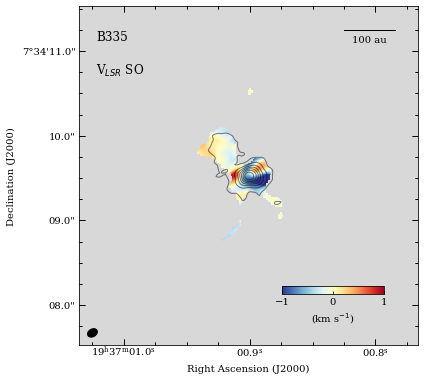

In [19]:
text_color = 'black'
Molecule = 'SO'

hdu = load_cutout(file_vc_SO)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='RdYlBu_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data - vlsr, vmin=-1, vmax=1, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_so=True, contour_cont=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([-1,0,1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'V$_{LSR}$ SO', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)

# SO TdV

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]

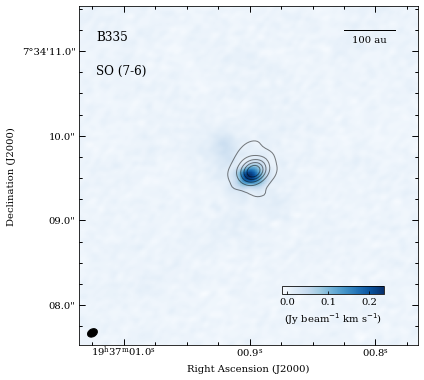

In [38]:
text_color = 'black'
Molecule = 'SO'

hdu = load_cutout(file_TdV_SO)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_cont=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'SO (7-6)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('figs/NGC1333_SiO_TdV.pdf', dpi=200)

# $N_2H+$ Vlsr

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


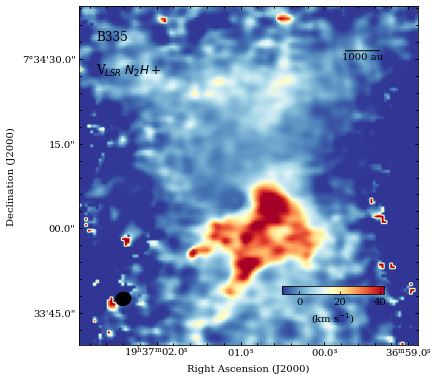

In [94]:
text_color = 'black'
Molecule = 'N2Hp'

hdu = load_cutout(file_vc_N2Hp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='RdYlBu_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data - vlsr, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_so=False, contour_cont=False)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(km s$^{-1}$)', orientation='horizontal')
#cbar.set_ticks([-1,0,1])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'V$_{LSR}$ $N_2H+$', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('Documents/Figures/B335_SO_Vlsr.png', dpi=200)

# $N_2H+$ TdV

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


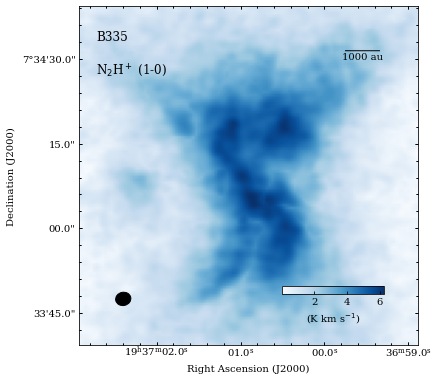

In [92]:
text_color = 'black'
Molecule = 'N2Hp'

hdu = load_cutout(file_TdV_N2Hp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 2, 4, 6])

fig.text(xpos_lab1, ypos_lab1, 'B335', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'N$_2$H$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
#fig.savefig('figs/NGC1333_N2Hp_TdV.pdf', dpi=200)
